In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import calculate_rmsd as rmsd

%matplotlib inline

In [95]:
def kabsch(P,Q):
    """
    Rotate and translate matrix P unto matrix Q using Kabsch algorithm.
    An optional vector of weights W may be provided.
    Parameters
    ----------
    P : array
        (N,D) matrix, where N is points and D is dimension.
    Q : array
        (N,D) matrix, where N is points and D is dimension.
    W : array or None
        (N) vector, where N is points.
    Returns
    -------
    P : array
        (N,D) matrix, where N is points and D is dimension,
        rotated and translated.
        
    U: array
        (D,D) matrix, where D is dimension. This is
        the rotation matrix.
    QC array
        (1,D) array, centroid of Q matrix to be added to
        new points post rotation by U.
    """
    # calculate centroid of both vectors points
    QC = Q.mean(axis=0)
    PC = P.mean(axis=0)
    
    # calculate new Q & P centered at the origin
    Q = Q - QC
    P = P - PC
    
    # Computation of the covariance matrix
    C = np.dot(np.transpose(P), Q)

    # Computation of the optimal rotation matrix
    # This can be done using singular value decomposition (SVD)
    # Getting the sign of the det(V)*(W) to decide
    # whether we need to correct our rotation matrix to ensure a
    # right-handed coordinate system.
    # And finally calculating the optimal rotation matrix U
    # see http://en.wikipedia.org/wiki/Kabsch_algorithm
    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]

    # Create Rotation matrix U
    U = np.dot(V, W)
    
    # Rotate P
    P = np.dot(P, U)
    
    # Calculate new points
    P = P + QC
    
    # Still need to return transformation matrix...
    
    
    return P, U, QC

In [96]:
N = 10;
x,y,z = np.random.randint(-5,5,N),np.random.randint(-5,5,N),np.random.randint(-5,5,N);

In [97]:
df = pd.DataFrame(data=[x,y,z], index=['x','y','z']).transpose()

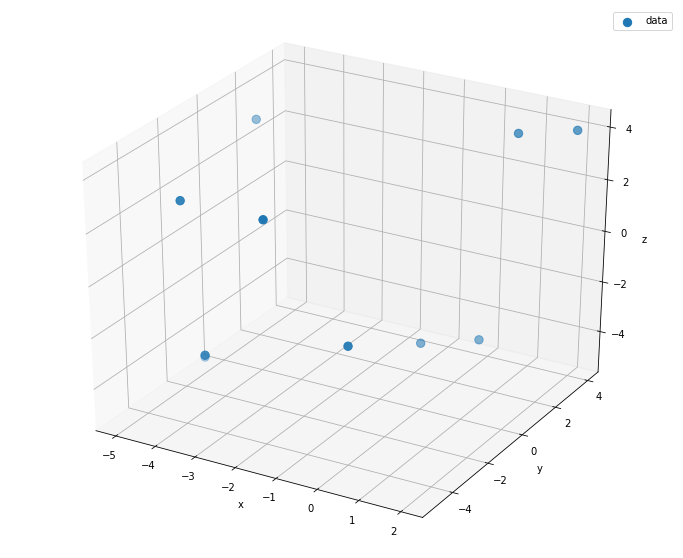

In [98]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'],df['y'],df['z'], c='C0', s=70)
ax.legend(['data', 'Origin1'])
ax.set_xlabel('x');ax.set_ylabel('y');ax.set_zlabel('z');
fig.set_size_inches(12, 10)
plt.show()

In [99]:
# angles of rotation for x,z
theta = 180*np.pi/180
phi = 90*np.pi/180


# Matrix to rotate about x axis
Rx = np.array([[1,0,0],[0,np.cos(theta),-np.sin(theta)],[0,np.sin(theta),np.cos(theta)]])

# Matrix to rotate about z axis
Rz = np.array([[np.cos(phi),-np.sin(phi),0],[np.sin(phi),np.cos(phi),0],[0,0,1]])

# Translation values
tx,ty,tz = -5,0,20

# Matrix to translate by x,y,z
Tx = np.array([[1,0,0,tx],[0,1,0,ty],[0,0,1,tz],[0,0,0,1]])

# Perform matrix multiplications
x_rot = Rx@np.array(df[['x','y','z']]).transpose()
data_xlate = (Tx@np.append(x_rot, np.ones((1,N)),axis=0))[0:3,:]

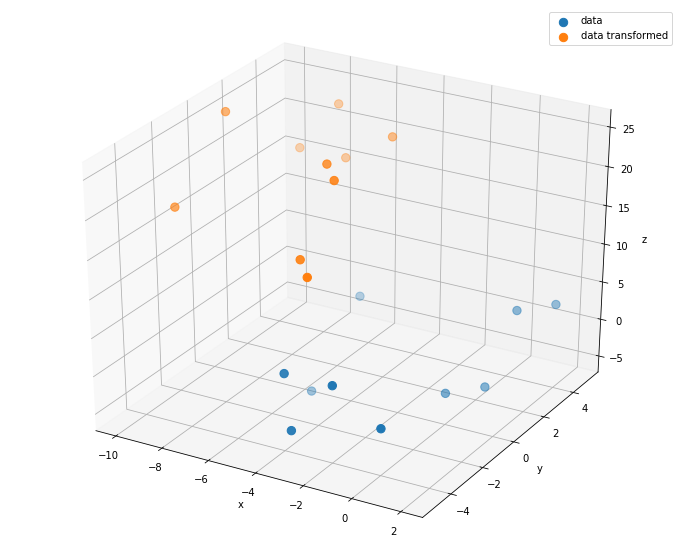

In [100]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'],df['y'],df['z'], c='C0', s=70)
ax.scatter(data_xlate[0,:],data_xlate[1,:],data_xlate[2,:], c='C1', s=70)
ax.legend(['data', 'data transformed'])
ax.set_xlabel('x');ax.set_ylabel('y');ax.set_zlabel('z');
fig.set_size_inches(12, 10)
plt.show()

Pass both arrays to a kabsch algorithm that can handle both rotation and translation.

In [111]:
A = np.array(df[['x','y','z']]).transpose().copy().transpose()
b = data_xlate.copy().transpose()

In [112]:
pred, rotation, translation = kabsch(b,A)

In [147]:
# Rotate P
points = np.dot(b - b.mean(0), rotation)

# Calculate new points
points = points + translation

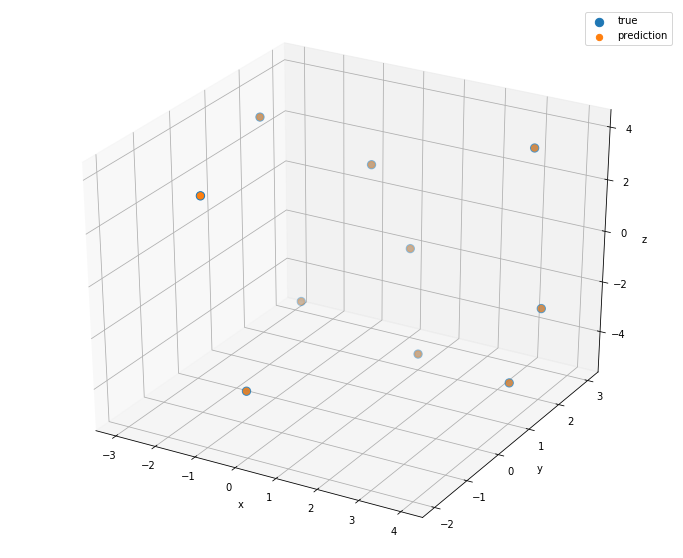

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'],df['y'],df['z'], c='C0', s=70)
ax.scatter(pred[:,0],pred[:,1],pred[:,2], c='C1', s=40)
ax.legend(['true', 'prediction'])
ax.set_xlabel('x');ax.set_ylabel('y');ax.set_zlabel('z');
fig.set_size_inches(12, 10)
plt.show()

### Test Data

In [21]:
test_x = [0,1,0,0,1,0,0]
test_y = [0,1,1,0,1,1,0]
test_z = [0,1,1,2,3,3,4]

test_df = pd.DataFrame(data=[test_x,test_y,test_z], index=['x','y','z']).transpose()

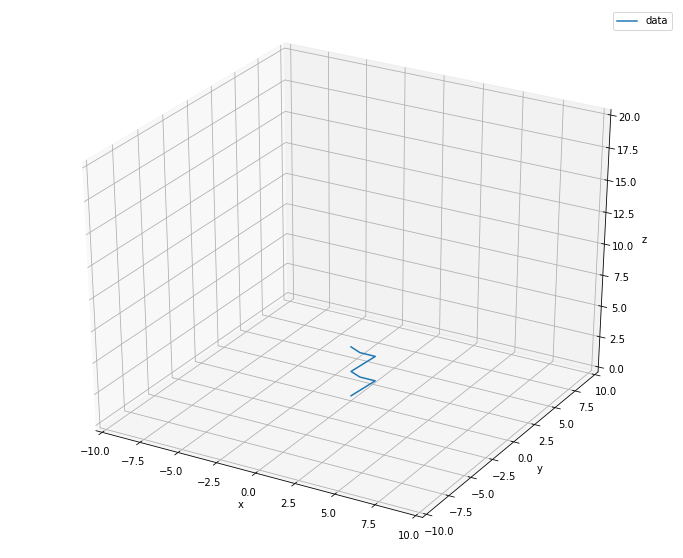

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(test_df['x'],test_df['y'],test_df['z'], c='C0')
ax.legend(['data'])
ax.set_xlabel('x');ax.set_ylabel('y');ax.set_zlabel('z');
ax.set_xlim(-10,10); ax.set_ylim(-10,10); ax.set_zlim(0,20);
fig.set_size_inches(12, 10)
plt.show()

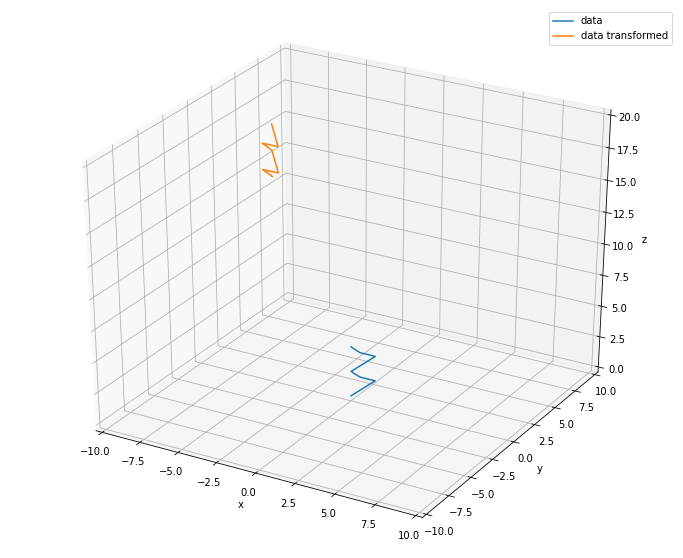

In [23]:
x_rot = Rx@np.array(test_df[['x','y','z']]).transpose()
data_xlate = (Tx@np.append(x_rot, np.ones((1,len(test_df))),axis=0))[0:3,:]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(test_df['x'],test_df['y'],test_df['z'], c='C0')
ax.plot(data_xlate[0,:],data_xlate[1,:],data_xlate[2,:], c='C1')
ax.legend(['data', 'data transformed'])
ax.set_xlabel('x');ax.set_ylabel('y');ax.set_zlabel('z');
ax.set_xlim(-10,10); ax.set_ylim(-10,10); ax.set_zlim(0,20);
fig.set_size_inches(12, 10)
plt.show()

In [24]:
A = np.array(test_df[['x','y','z']]).transpose().copy().transpose()
b = data_xlate.copy().transpose()

In [25]:
pred = rmsd.kabsch_fit(b,A)

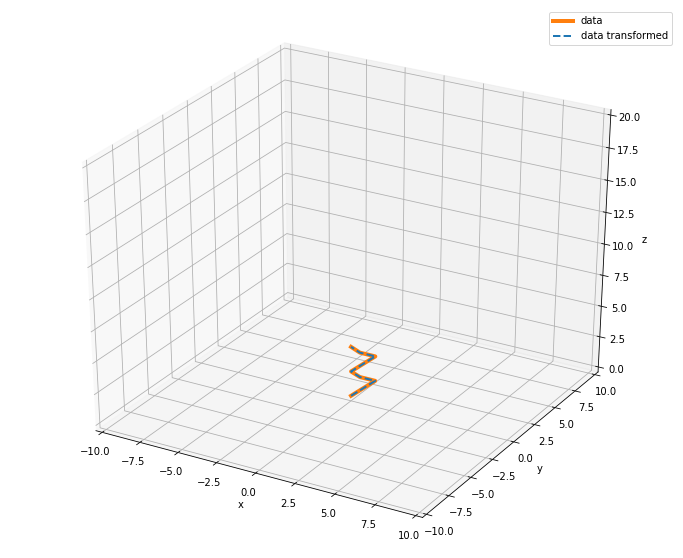

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(pred[:,0],pred[:,1],pred[:,2], c='C1', lw=4)
ax.plot(test_df['x'],test_df['y'],test_df['z'], c='C0', lw=2, ls='--')
ax.legend(['data', 'data transformed'])
ax.set_xlabel('x');ax.set_ylabel('y');ax.set_zlabel('z');
ax.set_xlim(-10,10); ax.set_ylim(-10,10); ax.set_zlim(0,20);
fig.set_size_inches(12, 10)
plt.show()

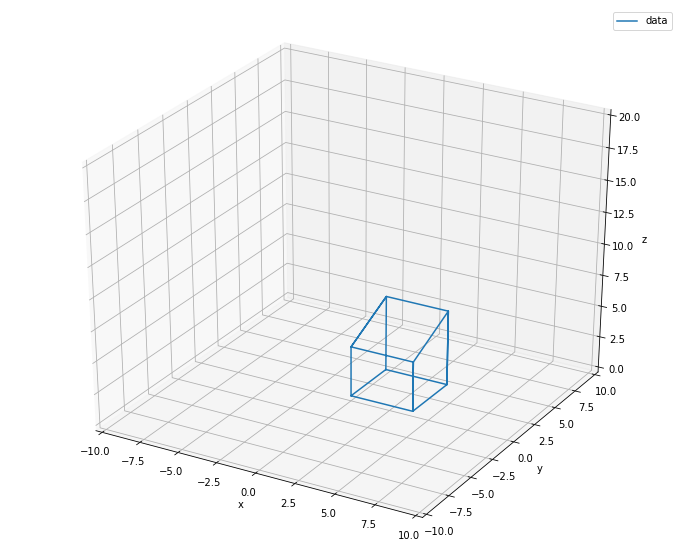

In [27]:
x1 = [0,0,4,4,0,0,0,0,4,4,4,4,4,4,0,0,0]
y1 = [0,4,4,0,0,0,0,4,4,4,4,0,0,0,0,4,4]
z1 = [0,0,0,0,0,0,4,6,6,0,6,4,0,4,4,6,0]

test_df = pd.DataFrame(data=[x1,y1,z1], index=['x','y','z']).transpose()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(test_df['x'],test_df['y'],test_df['z'], c='C0')
ax.legend(['data'])
ax.set_xlabel('x');ax.set_ylabel('y');ax.set_zlabel('z');
ax.set_xlim(-10,10); ax.set_ylim(-10,10); ax.set_zlim(0,20);
fig.set_size_inches(12, 10)
plt.show()

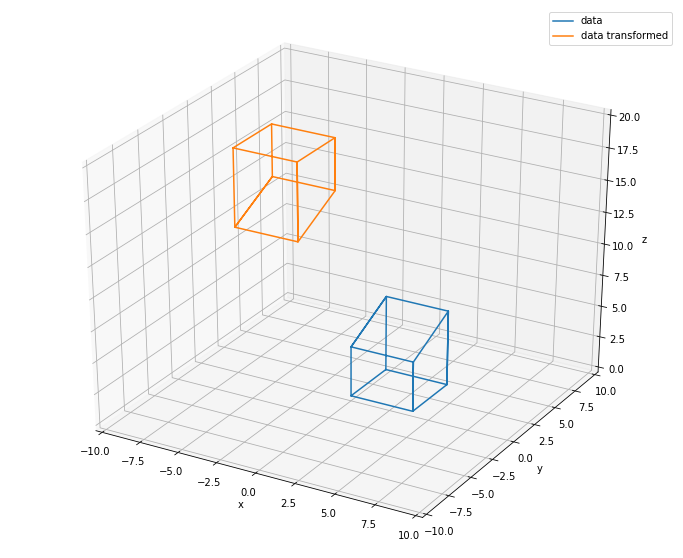

In [28]:
x_rot = Rx@np.array(test_df[['x','y','z']]).transpose()
data_xlate = (Tx@np.append(x_rot, np.ones((1,len(test_df))),axis=0))[0:3,:]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(test_df['x'],test_df['y'],test_df['z'], c='C0')
ax.plot(data_xlate[0,:],data_xlate[1,:],data_xlate[2,:], c='C1')
ax.legend(['data', 'data transformed'])
ax.set_xlabel('x');ax.set_ylabel('y');ax.set_zlabel('z');
ax.set_xlim(-10,10); ax.set_ylim(-10,10); ax.set_zlim(0,20);
fig.set_size_inches(12, 10)
plt.show()

In [29]:
A = np.array(test_df[['x','y','z']]).transpose().copy().transpose()
b = data_xlate.copy().transpose()

pred = rmsd.kabsch_fit(b,A)

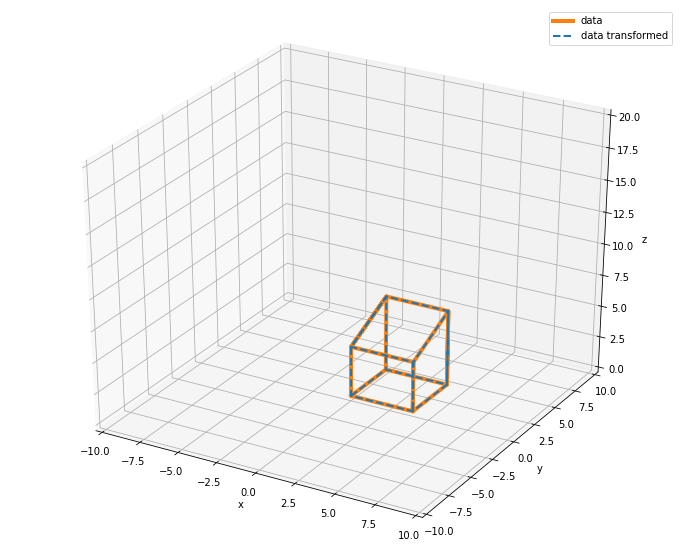

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(pred[:,0],pred[:,1],pred[:,2], c='C1', lw=4)
ax.plot(test_df['x'],test_df['y'],test_df['z'], c='C0', ls='--', lw=2)
ax.legend(['data', 'data transformed'])
ax.set_xlabel('x');ax.set_ylabel('y');ax.set_zlabel('z');
ax.set_xlim(-10,10); ax.set_ylim(-10,10); ax.set_zlim(0,20);
fig.set_size_inches(12, 10)
plt.show()

In [31]:
import plotly.graph_objects as go
# Read data from a csv
z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')
z = (np.abs(z_data.values / np.max(z_data.values)))**(1/2)
sh_0, sh_1 = z.shape
x, y = np.linspace(0, 1, sh_0), np.linspace(0, 1, sh_1)
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [32]:
xm,ym = np.meshgrid(x,y)

In [33]:
bruno_df = pd.DataFrame(data = [xm.flatten(),ym.flatten(),z.flatten()], index=['x','y','z']).transpose()

In [34]:
z_rot = Rz@np.array(bruno_df[['x','y','z']]).transpose()

In [35]:
fig = go.Figure(data=[
    go.Surface(z=z, x=x, y=y),
    go.Surface(x=z_rot[0,:].reshape((25,25)), y=z_rot[1,:].reshape((25,25)), z=z_rot[2,:].reshape((25,25)))
])
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

# Proposed Problem

In [155]:
A = np.array([[4,4,6], [0,0,4], [4,0,0]])
b = np.array([[4*np.sqrt(2),4*np.sqrt(2),6], [0,4*np.sqrt(2),4], [2*np.sqrt(2),2*np.sqrt(2),0]])

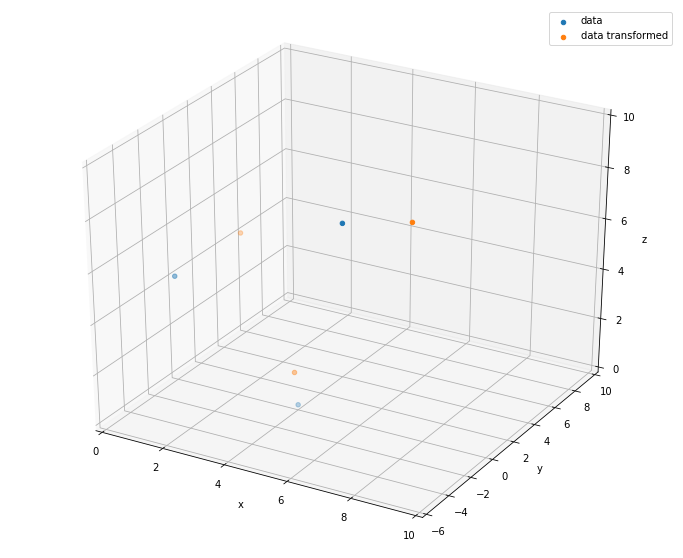

In [163]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(A[:,0],A[:,1],A[:,2], c='C0')
ax.scatter(b[:,0],b[:,1],b[:,2], c='C1')
ax.legend(['data', 'data transformed'])
ax.set_xlabel('x');ax.set_ylabel('y');ax.set_zlabel('z');
ax.set_xlim(0,10); ax.set_ylim(-6,10); ax.set_zlim(0,10);
fig.set_size_inches(12, 10)
plt.show()

In [181]:
A = np.array([[4,4,6], 
              [0,0,4], 
              [4,0,0]])
b = np.array([[4*np.sqrt(2),4*np.sqrt(2),6], 
              [0,4*np.sqrt(2),4], 
              [2*np.sqrt(2),2*np.sqrt(2),0]])

In [182]:
pred, rotation, translation = kabsch(b,A)

In [183]:
np.round((np.array([[0,0,0]]) - b.mean(0))@rotation + translation,2)

array([[ 4., -4.,  0.]])